In [ ]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
import sys
import os
sys.path.append('../')
from  util.model import DINOHead,MLP
root = "/opt/data/private/stable_diffusion_model"
textual_name = "textual_inversion_find_new_style_864_1"
model_id = "stabilityai/stable-diffusion-2-1"
out_dim  = 864
moldel_root = f'{root}/{textual_name}/model_2500.pt'
state_dict = torch.load(moldel_root)['model']
backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16',map_location='cpu')
head = MLP(in_dim=768, out_dim=out_dim,bottleneck_dim=1024,nlayers=3)
model = torch.nn.Sequential(backbone, head)
model.load_state_dict(state_dict)
model.cuda(1)
image_root = '../datasets/sub_style_dataset'
image_size = 224
crop_pct = 0.875
interpolation = 3
tras = transforms.Compose([
    transforms.Resize(int(image_size / crop_pct),interpolation=interpolation),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),])
dataset = ImageFolder(image_root,transform=tras)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)
name =''
for x in model_id.split('/'):
    name += x+'_'
name =name+f"pca_{ 768 if out_dim==1024 else out_dim}.pt"
save_path = os.path.join('..',"token_dict", name)
token_dict = torch.load(save_path)

In [ ]:
import numpy as np
import torch.nn.functional as F
import csv
for x in token_dict:
    token_dict[x] =token_dict[x].to('cuda:1')
headers = [x for x in range(1024)]
rows = []
fearture = [x for x in range(768)]
fearture_rows=[]
with torch.no_grad():
    for i, (img, label) in enumerate(dataloader):
        img = img.cuda(1)
        weight,bais = model(img)
        weight = F.normalize(weight, dim=-1)
        weight = 31.2*weight
        bais = F.normalize(bais, dim=-1)
        bais = 7.2*bais
        weight = torch.matmul(weight,token_dict['features'])+bais
        weight = weight*token_dict['std']+token_dict['mean']
        print(weight.norm(dim=-1))
        # logits = logits.softmax(dim=-1)
        # logits = logits[0].cpu().numpy()

        # true_name = dataset.classes[int(label.numpy())]
        # pred_name = dataset.classes[np.argmax(logits)]
        # prob = np.max(logits)
        rows.append(('{:.4}'.format(x) for x in weight[0].cpu().numpy()))
        # fearture_rows.append(('{:.4}'.format(x) for x in x[0].cpu().numpy()))
        # print(f'{true_name},{pred_name},{logits}')
with open('result.csv','w',encoding='utf8',newline='') as f :
    writer = csv.writer(f)
    writer.writerow(headers)
    writer.writerows(rows)
# with open('fearture.csv','w',encoding='utf8',newline='') as f :
#     writer = csv.writer(f)
#     writer.writerow(fearture)
#     writer.writerows(fearture_rows)

In [1]:
import torch
from diffusers import StableDiffusionXLPipeline
import matplotlib.pyplot as plt
from pytorch_lightning import seed_everything
model_id = '../stabilityai/stable-diffusion-xl-base-1.0'
pipeline = StableDiffusionXLPipeline.from_pretrained(model_id,torch_dtype=torch.float16).to('cuda:0')
pipeline.unet.requires_grad_(False)
pipeline.unet.eval()
pipeline.vae.requires_grad_(False)
pipeline.vae.eval()
pipeline.text_encoder.requires_grad_(False)
pipeline.text_encoder.eval()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

Seed set to 42


MasaCtrl at denoising steps:  [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
MasaCtrl at U-Net layers:  [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]


  0%|          | 0/50 [00:00<?, ?it/s]

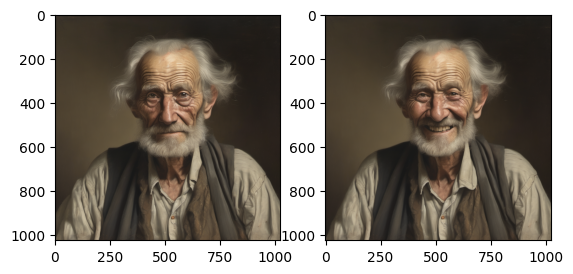

In [2]:
import sys
sys.path.append('../')
from util.masactrl import MutualSelfAttentionControl
from util.ptp_utils import regiter_attention_editor_diffusers

seed = 42
seed_everything(seed)
device = pipeline.device
prompts = ["A portrait of an old man, facing camera, best quality",
          "A portrait of an old man, facing camera, smiling, best quality"
]
STEP = 4
LAYER = 44
start_code = torch.randn([1, 4, 128, 128], device=device,dtype=torch.float16)
start_code = start_code.expand(len(prompts), -1, -1, -1)
editor = MutualSelfAttentionControl(STEP, LAYER, model_type="SDXL")
regiter_attention_editor_diffusers(pipeline, editor)
output = pipeline(prompts, latents=start_code, guidance_scale=7.5)
image1 = output.images[0]
# image1.save(f"A portrait of an old man, facing camera, best quality.jpg")
image2 = output.images[1]
# image2.save(f"A portrait of an old man, facing camera, smiling, best quality.jpg")
plt.subplot(1,2,1)
plt.imshow(image1)
plt.subplot(1,2,2)
plt.imshow(image2)
torch.cuda.empty_cache()

In [ ]:
import os
import random
import matplotlib.pyplot as plt
prompts = ["panda","cat","dog","anemone fish","hen","bee eater","box turtle","African elephant","rat","lion"]
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]
root = "../sample_dataset/"
for p in prompts:
    templates = random.choice(imagenet_templates_small)
    prompt = templates.format(p)
    image_path = os.path.join(root,p)
    os.makedirs(image_path,exist_ok=True)
    for seed in range(100,200):
        g = torch.Generator('cuda').manual_seed(seed)
        output = pipeline(prompt,generator=g)
        image = output.images[0]
        plt.imsave(image,f"{image_path}/{seed}.jpg")
print("Done!")
# # 显示原图像和处理后的图像
# plt.imshow(image)

In [2]:
import torch
from diffusers import StableDiffusionPipeline,AutoPipelineForText2Image
model_id = '../stabilityai/stable-diffusion-xl-base-1.0'
pipeline = AutoPipelineForText2Image.from_pretrained(model_id,torch_dtype=torch.float16)
pipeline.unet.enable_xformers_memory_efficient_attention()
pipeline = pipeline.to('cuda:1')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

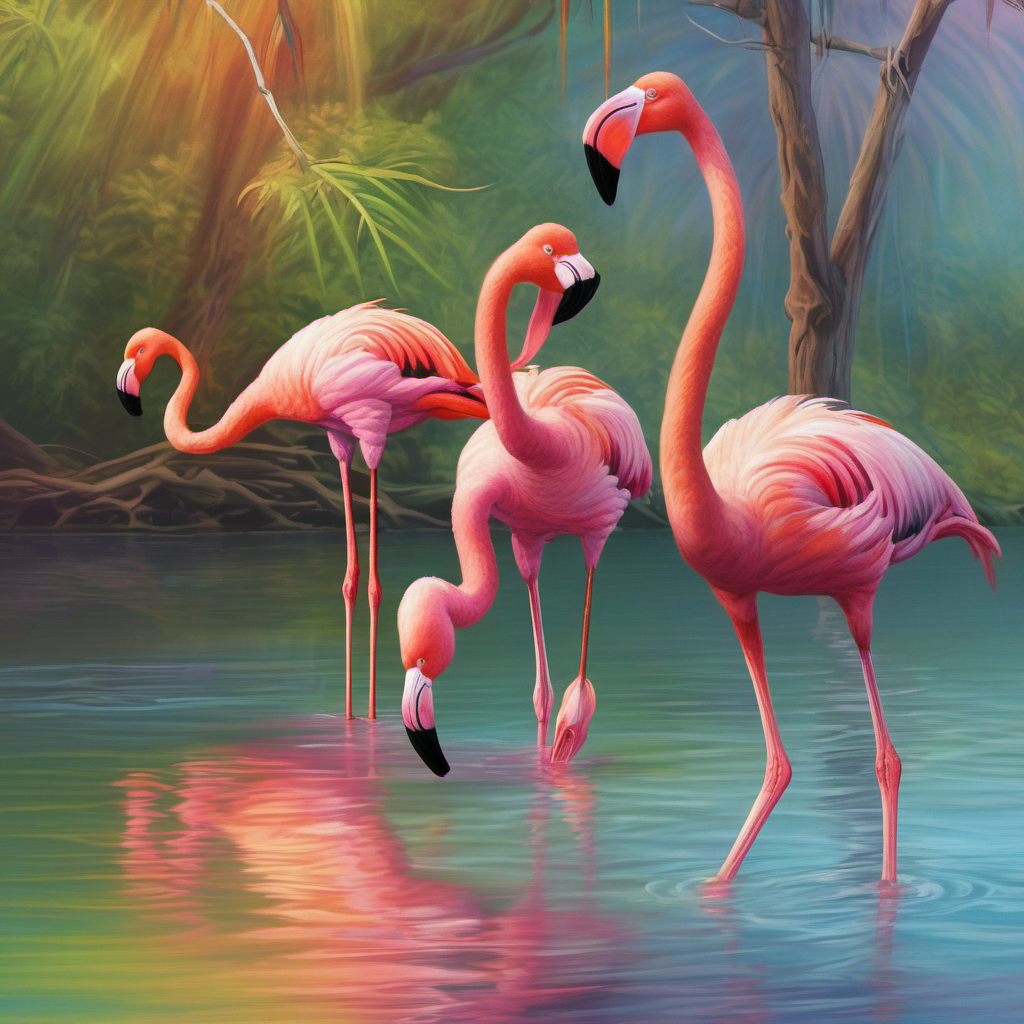

: 

In [3]:
prompt = "rainbow-colored flamingos standing in the water near a tree."
g = torch.Generator('cuda').manual_seed(1)
output = pipeline(prompt,num_inference_steps=50,guidance_scale=7.5,generator=g)
image = output.images[0]
image.resize((512,512))
image.show()

In [ ]:
from sklearn.cluster import KMeans
import os
token_embeds = pipeline.text_encoder.get_input_embeddings().weight.data
token_embeds = token_embeds.numpy()
mean_token = np.mean(token_embeds,axis=0)
var_token = np.var(token_embeds,axis=0)
standard_token = (token_embeds-mean_token)/var_token
kmeans = KMeans(n_clusters=768, random_state=0).fit(token_embeds)
cluster_centers = kmeans.cluster_centers_
token_dict = torch.from_numpy(cluster_centers)
save_path = os.path.join('../token_dict', "cluster_centers.pt")
torch.save(token_dict, save_path)

In [ ]:
import os
save_path = os.path.join('../token_dict', "stable-diffusion-2-1.pt")
torch.save(token_dict, save_path)

In [ ]:
g = torch.Generator('cuda').manual_seed(0)
pipeline = pipeline.to('cuda:0')
prompt = "A photo of elephant"
output = pipeline(prompt,generator=g)
image = output.images[0]
# image.save(f"A picture of a baby with question marks on his face.jpg")
image.show()

In [ ]:
from safetensors import safe_open
import os
import csv
root = "/opt/data/private/stable_diffusion_model"
textual_name = "textual_inversion_find_new_9"
path = os.path.join(root,textual_name,"learned_embeds.safetensors")
weight = {}
with safe_open(path, framework="pt", device=0) as f:
    for k in f.keys():
        weight[k] = f.get_tensor(k)
token = weight['<object>']

headers = [x for x in range(1024)]
rows = []
for t in token:
    rows.append(('{:.4}'.format(x) for x in t.cpu().numpy()))
with open('token.csv','w',encoding='utf8',newline='') as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    writer.writerows(rows)